# 1 Visualizing convnets activations

In [1]:
from keras.models import load_model 
model = load_model('cats_and_dogs_small_2.h5')
model.summary()


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [2]:
# Preprocessing a single image
img_path = '/Users/anhpham/Projects/DLWP_Manning/Chapter5/Dogs-vs-Cats-small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size =(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor/=255. # note that the model was trained on inputs that were preprocessed this way 

print(img_tensor.shape)



(1, 150, 150, 3)


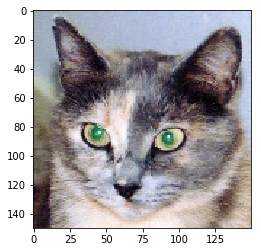

In [3]:
# Displaying the test picture
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [5]:
# Instantiating a model from an input tensor and a list of output tensors

from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)


In [6]:
# Running the model in predict mode
activation = activation_model.predict(img_tensor)
first_layer_activation = activation[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


Populating the interactive namespace from numpy and matplotlib


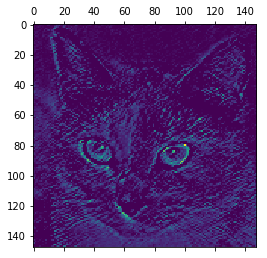

In [11]:
# Visualizing the fourth channel
%pylab inline

import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 4], cmap = 'viridis')


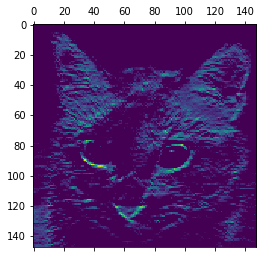

In [14]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 7], cmap = 'viridis')

/Users/anhpham/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in divide


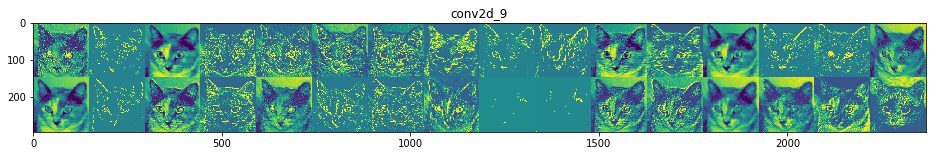

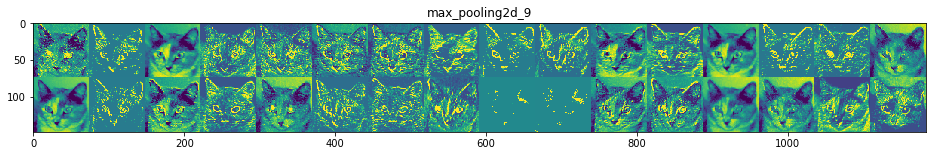

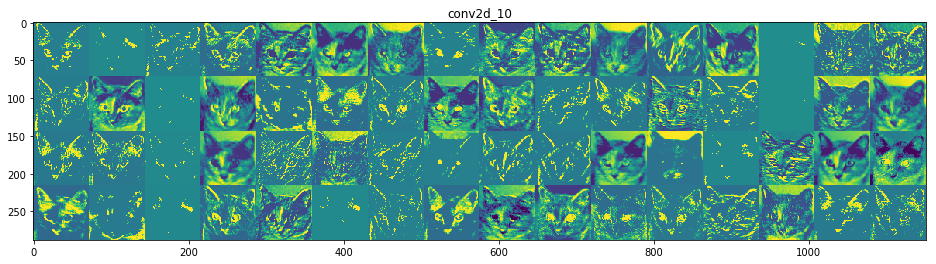

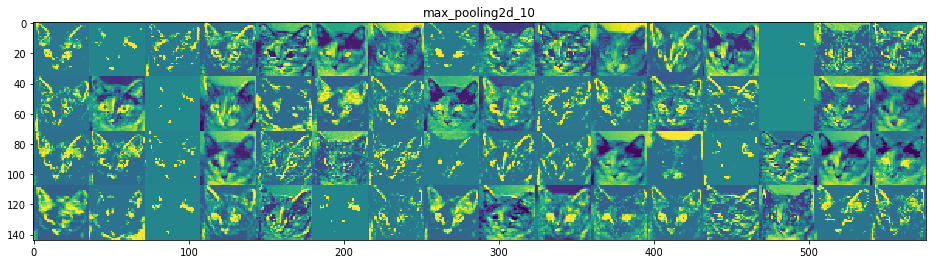

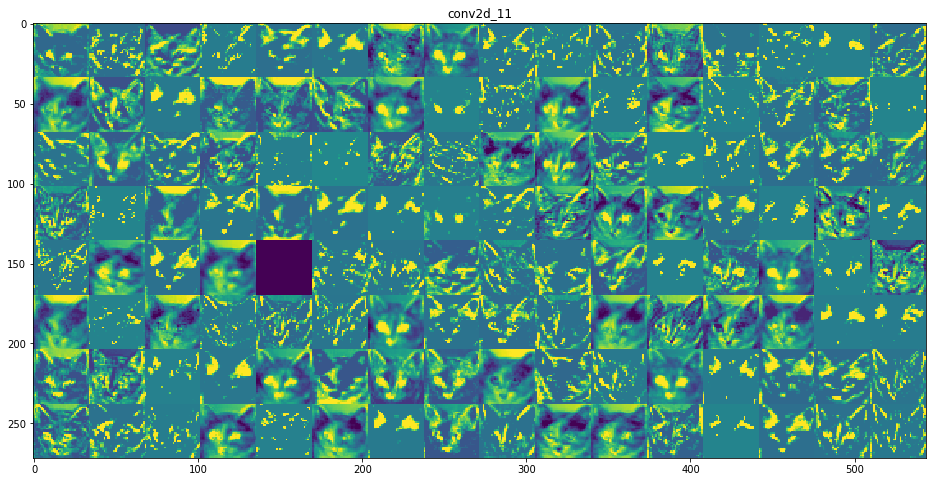

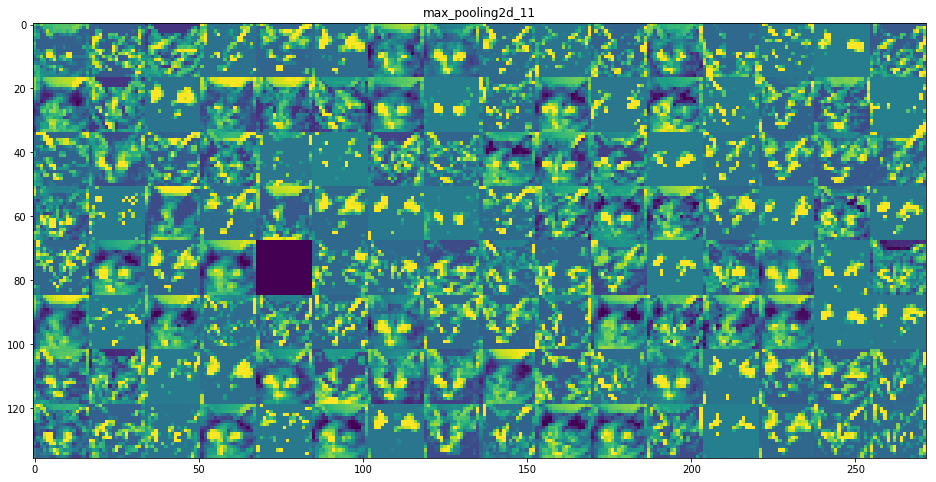

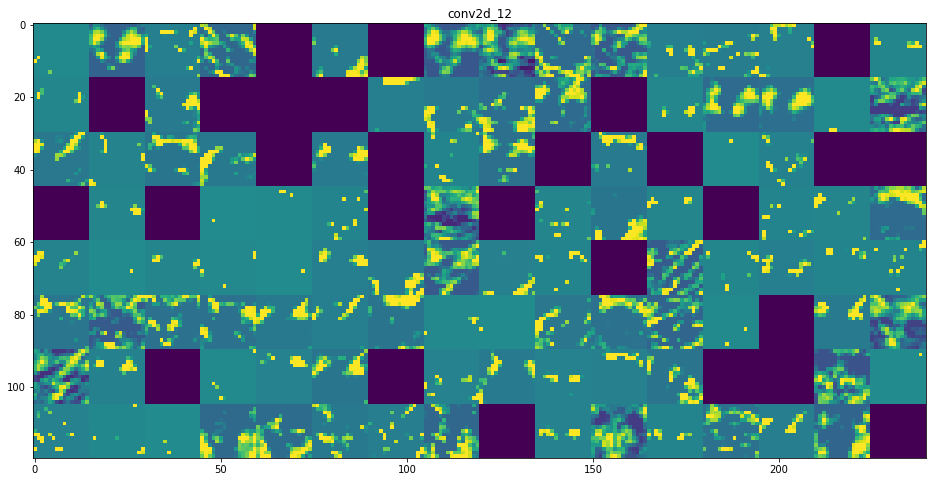

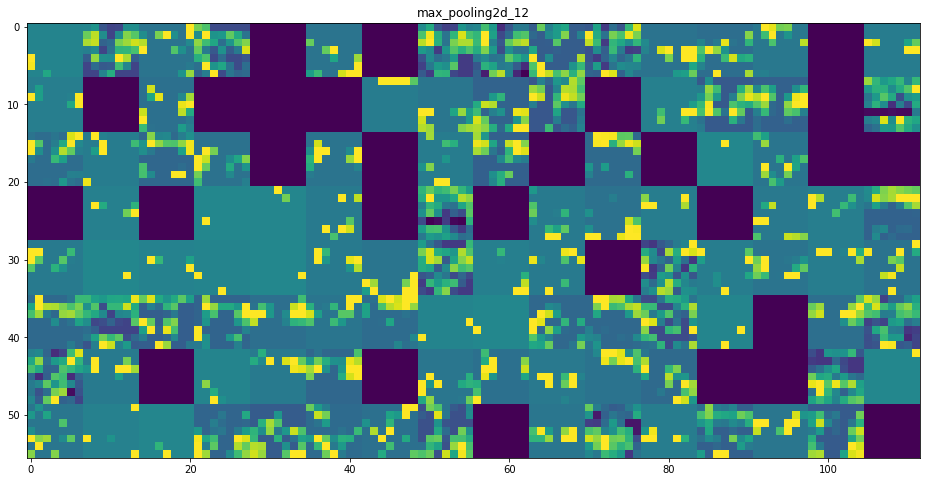

In [21]:
# Visualizing every channel in every intermediate activation

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activation): # Display the feature maps
    n_features = layer_activation.shape[-1] # the feature map has shape (l, size, size, n_features)
    
    size  = layer_activation.shape[1]
    
    n_cols = n_features//images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size*n_cols, images_per_row*size))
    
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col*images_per_row + row]
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *=64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size: (col+1)*size, 
                        row*size:(row+1)*size] = channel_image
            
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1],
                       scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap ='viridis')
    
            

The activations of higher layers carry less information about the specific input being seen, and more about the target class. A deep neural network effectively acts as an information distillation pipeline, with raw data going in and being repeatedly transformed so that irrelevant information is filtered out. 

# 2. Visualizing convnet filters

The process:
- build a loss function that maximizes the value of a given filter n a given convolution layer
- use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value


In [22]:
# Defining the loss tensor for filter visualization

from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights = 'imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])



In [23]:
grads = K.gradients(loss, model.input)[0]

In [24]:
# Gradient-normalization trick 
# to ensures that the magnitude of the updates doen to the input image is always within the same range
grads/= (K.sqrt(K.mean(K.square(grads)))+ 1e-5) 

In [25]:
# Fetching Numpy output values given Numpy input values

iterate = K.function([model.input],[loss,grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1,150,150,3))])

# Loss maximization via stochastic gradient descent

input_img_data = np.random.random((1,150,150,3))*20 + 128.

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value*step
    
# Utility function to convert a tensor into a valid image

def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x*=0.1
    
    x+=0.5
    x=np.clip(x,0,255).astype('uint8')
    return x



In [30]:
# Function to generate filter visualizations
def generate_pattern(layer_name, filter_index, size = 150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads)))+ 1e-5)
    iterate = K.function([model.input],[loss,grads])
    input_img_data = np.random.random((1,size,size,3))*20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value*step
        
    img = input_img_data[0]
    return deprocess_image(img)

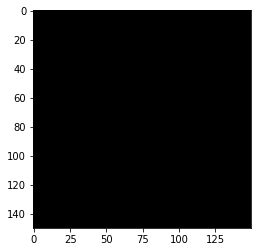

In [31]:
plt.imshow(generate_pattern('block3_conv1',0))

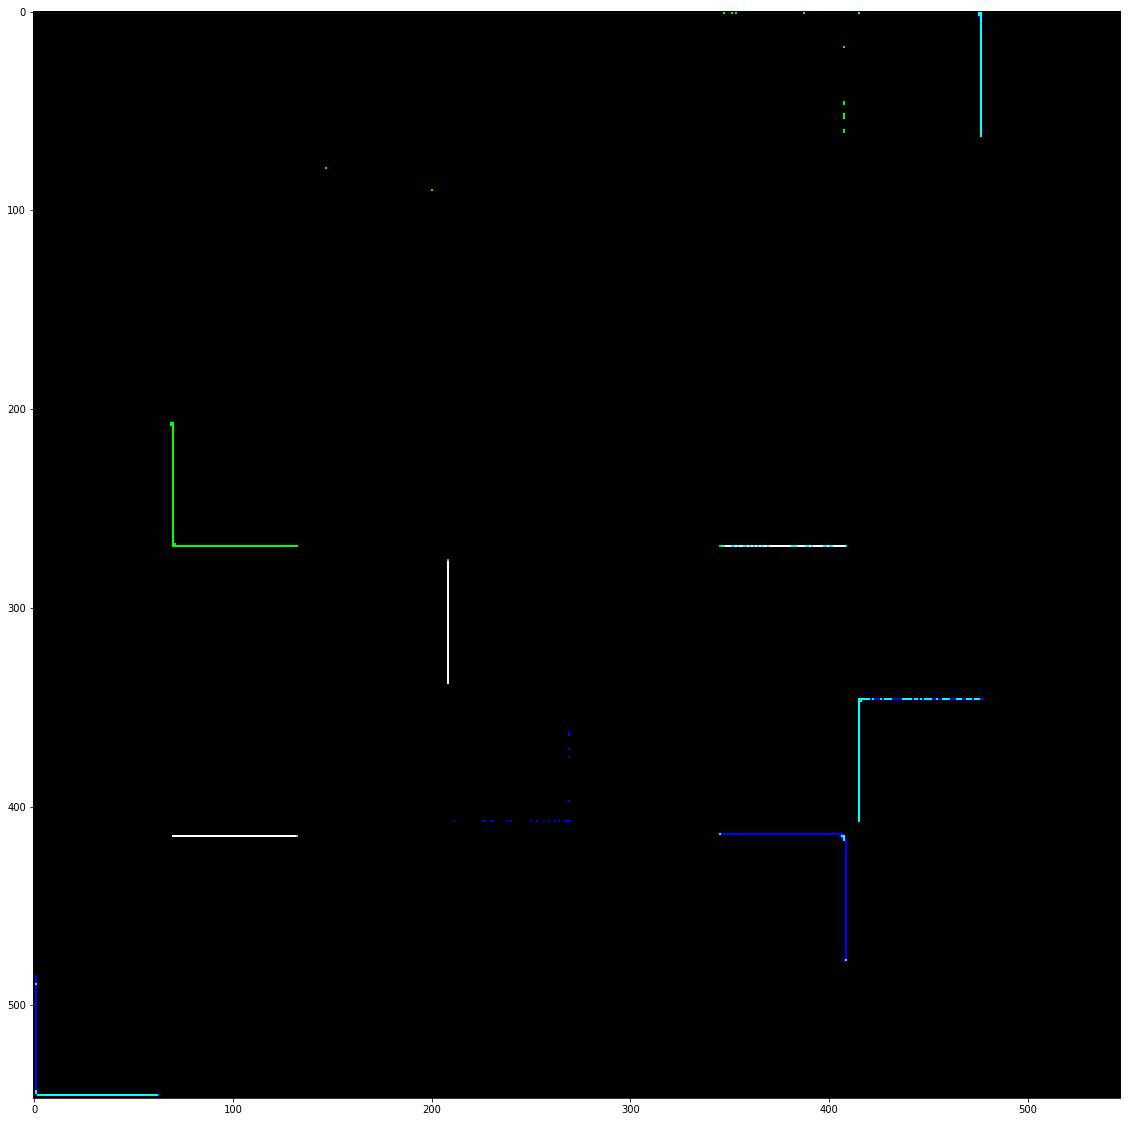

In [33]:
# Generating a grid of all filter response patterns in a layer
layer_name = 'block1_conv1'
size = 64
margin = 5

# create an empty image to store results
results = np.zeros((8*size + 7*margin, 8*size + 7*margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j*8), size = size)
        horizontal_start = i*size + i*margin
        horizontal_end = horizontal_start + size
        vertical_start = j*size + j*margin
        vertical_end = vertical_start + size
        results[horizontal_start:horizontal_end, vertical_start:vertical_end,:] = filter_img
        
plt.figure(figsize = (20,20))
plt.imshow(results)

Each layer in a convnet learns a collection of filters such that their inputs can be expressed as a combination of the filters.

# 3. Visualizing heatmaps of class activation
To udnerstand which parts of a given image lead a convnet to its final classification decision. This is helpful for debugging the decision process of a convnet, particularly in the case of classification mistake.

In [34]:
# Loading the VGG16 network with pretrained weights

from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

553476096/553467096 [==============================] - 167s 0us/step


What VGG16 can read: images of size 224 x 225, preprocessed according to a few rules that are packaged in keras.applivations.vgg16.preprocess_input
=> need to load the image, resize to 224 x 224, convert to numpy float32 tensor and apply these preprocessing rules

In [35]:
# Preprocessing an input image for VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = '/Users/anhpham/Projects/DLWP_Manning/Chapter5/elephant.jpg'
img=image.load_img(img_path, target_size = (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)

In [36]:
preds = model.predict(x)

In [37]:
print('Predicted:', decode_predictions(preds, top=3)[0])

49152/35363 [=========================================] - 1s 11us/step
('Predicted:', [(u'n02504013', u'Indian_elephant', 0.7769087), (u'n01871265', u'tusker', 0.12477513), (u'n02504458', u'African_elephant', 0.097515106)])


In [39]:
# Setting up a grad class activation map (GradCAM) algorithm

african_elephant_output = model.output[:,386]
last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis = (0,1,2))
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value  = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :,i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis = -1)


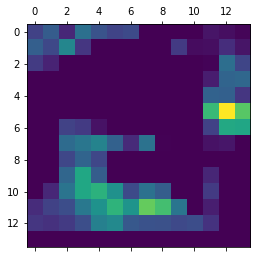

In [40]:
# Heatmap post-processing
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [41]:
# Use OpenCV to generate an image that superimposes the original image on the heatmap 
# Superimposing the heatmap with the original picture

import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap*0.4 + img
cv2.imwrite('/Users/anhpham/Projects/DLWP_Manning/Chapter5/elephant_cam.jpg',superimposed_img)

ImportError: No module named cv2